In [50]:
import gym 
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import Sequential, Linear, ReLU, Module
from tqdm.notebook import tqdm_notebook
from torch.optim import Adam
import math 
import random
from torch.nn.functional import mse_loss
import torch.nn.functional as F
import itertools
from torch.distributions import Categorical

In [51]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from multiprocessing_env import SubprocVecEnv

## PPO (Proximal policy approximation)

In [52]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
        )
                
    def forward(self, x):
        value = self.critic(x)
        out    = self.actor(x)
        out = F.softmax(out, dim=-1)
        dist =  Categorical(out)
        return value, dist

In [67]:
dev = torch.device('cpu')
hidden_size = 20
actor_critic = ActorCritic(4, 2, hidden_size)

In [68]:
class Reward_counter() :
    def __init__(self, n_wokers) :
        self.n_workers = n_workers
        self.reset()
        
    def reset(self) :
        self.reward_log = [[] for i in range(self.n_workers)]
        self.acc_reward = np.zeros(self.n_workers)
        
    def update(self, rewards, dones) :
        for i, (r, done) in enumerate(zip(rewards, dones)) :
            self.update_worker(i, r, done)
            
    def update_worker(self, i, reward, done) :
        self.acc_reward[i] += reward
        if done : 
            self.reward_log[i].append(self.acc_reward[i])
            self.acc_reward[i] = 0
        
    def plot_results(self, conv=100) :
        plt.title('Reward avg per workers over episodes')
        plt.xlabel('Episode')
        plt.ylabel('Reward avg')
        for i in range(self.n_workers) :
            rew_worker = rewards_avg = np.convolve(self.reward_log[i], np.ones((conv,))/conv, mode='valid')
            plt.plot(rew_worker, label=f'worker {i}')
        plt.show()

In [69]:
num_envs = 16
env_name = "CartPole-v0"

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

env = gym.make(env_name)

In [70]:
def batch_iter(advantage, ob_states, actions, log_probs, returns, batch_size=4) :
    for i in range(n_steps // batch_size) :
        idxs = np.random.permutation(range(n_steps))[:batch_size]
        yield advantage[idxs], ob_states[idxs], actions[idxs], log_probs[idxs], returns[idxs], idxs

In [71]:
n_episodes = 500
lr = 1e-3
gamma = 0.99
n_steps = 40
n_workers = num_envs
eps = 0.2
batch_size = 4
n_epochs = 4

stop_crit= 195
stop_crit_avg = 100


opt = Adam(actor_critic.parameters(), lr=lr)

r_counter = Reward_counter(n_workers)


for i in tqdm_notebook(range(n_episodes)) :
    
    rewards = torch.zeros((n_steps, n_workers), dtype=torch.float).to(dev)
    mask = torch.zeros((n_steps, n_workers), dtype=torch.float).to(dev)
    log_probs = torch.zeros((n_steps, n_workers), dtype=torch.float).to(dev)
    values = torch.zeros((n_steps, n_workers), dtype=torch.float).to(dev)
    actions = torch.zeros((n_steps, n_workers), dtype=torch.float).to(dev)
    ob_states = torch.zeros((n_steps, n_workers, 4), dtype=torch.float).to(dev)
    
    
    if i == 0 :
        observations = torch.tensor(envs.reset(), dtype=torch.float, device=dev)
    assert observations.shape == (n_workers, 4)
    
    
    step = 0
    while step < n_steps :
            
        vals, dist = actor_critic(observations)
        assert vals.shape == (n_workers, 1)
                    
        ob_states[step] = observations
        values[step] = vals.view(-1)
            
        #choose action
        act = dist.sample()
        log_probs[step] = dist.log_prob(act)
        actions[step] = act
            
        obs, r, dones, _ = envs.step(act.numpy())
        mask[step] = torch.tensor(1-dones).to(dev)
        rewards[step] = torch.from_numpy(r)
            
        observations = torch.tensor(obs, dtype=torch.float).to(dev)
            
        r_counter.update(r, dones)
        step+=1                   
    
    #discounted returns calculation (with bootstraping)
    returns = torch.zeros((n_steps, n_workers), dtype=torch.float).to(dev)
    with torch.no_grad() :
        q_val, _ = actor_critic(observations)
    q_val = q_val.view(-1).detach()
    for i in reversed(range(n_steps)) :
        q_val = rewards[i] + gamma * q_val * (mask[i])
        returns[i] = q_val
    advantage = (returns - values).detach()
    
    for epoch in range(n_epochs) :
        a = 0
        for adv_b, state_b, action_b, l_probs_b, returns_b, idxs in batch_iter(advantage, ob_states, actions, log_probs, returns.detach(), batch_size=batch_size) :
            
            vals, dist = actor_critic(state_b)
            
            new_actor_probs = dist.log_prob(action_b)
            
            #probability ration and clipped prob ration
            r = torch.exp((new_actor_probs) - (l_probs_b.detach()))
            clipped_r = torch.clamp(r, 1-eps, 1+eps)
            adv = returns_b.view(batch_size, n_workers, -1) - vals

            #critic loss
            critic_loss = adv.pow(2).mean()

            #actor loss
            clipped_loss = clipped_r * adv_b.detach()
            loss_ = r * adv_b.detach()
            actor_loss = -torch.min(clipped_loss, loss_).mean()
            
            opt.zero_grad()
            loss = 0.5 * (critic_loss + actor_loss)
            loss.backward()
            opt.step()
            
            
    

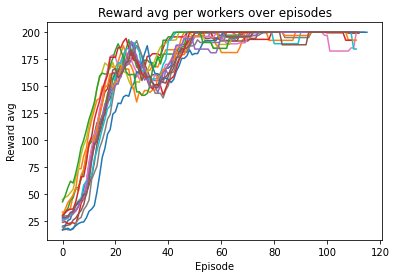

In [77]:
r_counter.plot_results(conv=10)